### ICEF, Derivatives course, Home assignment N2
Task 4 (c) 

Monte Carlo Valuation with Stochastic Volatility

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import optimize
from py_vollib.black_scholes import implied_volatility

ImportError: cannot import name 'constants' from 'py_vollib.black_scholes' (c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\py_vollib\black_scholes\__init__.py)

In [3]:
#support funck, compute discounted payoff for call option for given
#ST=final price, K=strike, T=time period, r=riskfree interest rate
def compute_payoff(ST, K, T, r):
    CT = max(ST - K, 0)
    PVCT = CT*np.exp(-r*T)
    
    return PVCT

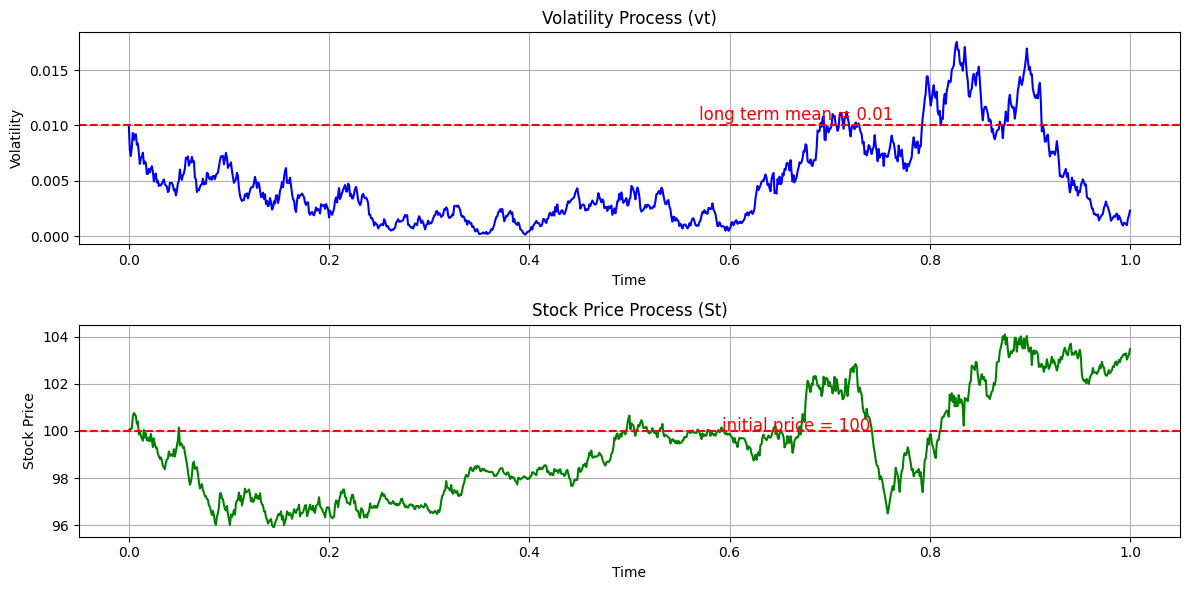

(3.477404618541513, 1, 0, 100)

In [21]:
#define the stochastic volatility model 
def stochastic_vol(theta=0.01, k=2, sigma=0.225, r=0, St=100, vt=0.01, lamda=0, T=0.5, steps=150, rho=0, plot=False, K=100):
    dt = T/steps

    St_series = [St]*(steps + 1)
    vt_series = [vt]*(steps + 1) 

    rng = np.random.default_rng()
    dW, dW_v = rng.multivariate_normal(mean=[0, 0], cov=[[dt, rho*dt],[rho*dt, dt]], check_valid='warn', size=steps).T

    for i in range(steps):
        vt = max(0.00001, vt + (k*(theta - vt) - lamda*sigma*np.sqrt(vt))*dt + sigma*np.sqrt(vt)*dW_v[i])

        St = St + r*St*dt + np.sqrt(vt)*St*dW[i]

        St_series[i+1] = St
        vt_series[i+1] = vt
    
    time = np.linspace(0, T, steps + 1)  

    if plot == True:
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 1, 1)
        plt.plot(time, vt_series, label='Volatility (vt)', color='blue')
        plt.axhline(y=theta, color='red', linestyle='--', label=f'Theta = {theta}')
        plt.text(T/1.5, theta + 0.0005, f'long term mean = {theta}', color='red', fontsize=12, ha='center')  # Caption for the line
        plt.title('Volatility Process (vt)')
        plt.xlabel('Time')
        plt.ylabel('Volatility')
        plt.grid(True)

        # Plot for St (stock price)
        plt.subplot(2, 1, 2)
        plt.plot(time, St_series, label='Asset Price (St)', color='green')
        plt.axhline(y=St_series[0], color='red', linestyle='--', label=f'S0 = {St_series[0]}')
        plt.text(T/1.5, St_series[0] + 0.0005, f'initial price = {St_series[0]}', color='red', fontsize=12, ha='center')  # Caption for the line
        plt.title('Stock Price Process (St)')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    
    PVCT = compute_payoff(St_series[-1], K, T, r)

    return PVCT, T, r, St_series[0]
    

stochastic_vol(T=1, steps=1000, plot=True)

    

In [168]:
#Black and Sholts call price formula 
def bs_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Implied volatility calculation
def implied_vol(S0, K, T, r, market_price):

    def objective_function(sigma):
        return bs_call_price(S0, K, T, r, sigma) - market_price

    # Fix the bounds for volatility, ensuring positive values
    vol = optimize.ridder(objective_function, -1e-10, 10)  # Volatility bounds, starting from a small positive value
   
    return vol

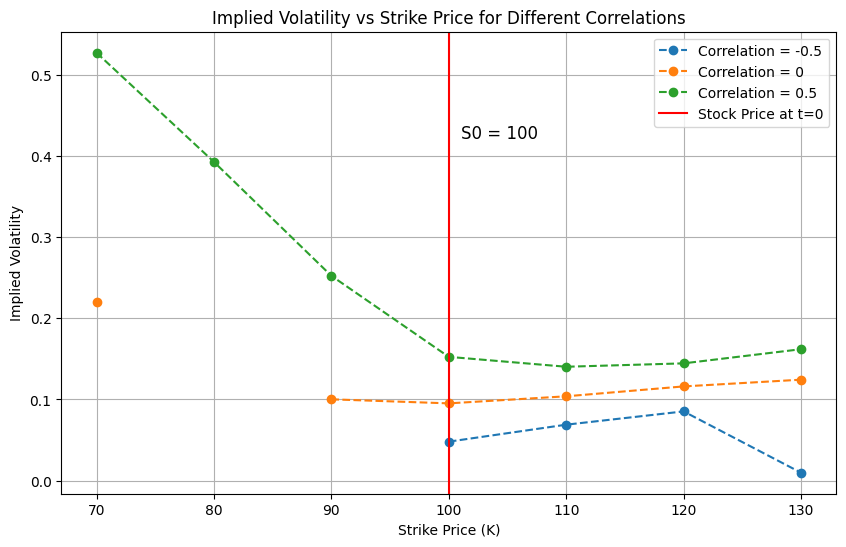

In [180]:
#plot implied volatilities for different correlations between underlying stochastic processes of stock price and volatility 
num_iter = 10000
correlations = [-0.5, 0, 0.5]

plt.figure(figsize=(10, 6))

for rho in correlations:
    strikes = [70, 80, 90, 100, 110, 120, 130]
    imp_vols = []

    for K in strikes:
        PVCT_sum = 0
        
        for i in range(num_iter):
            PVCT, T, r, S0 = stochastic_vol(rho=rho, K=K)
            PVCT_sum += PVCT

        aprox_c_opt_price = PVCT_sum / num_iter
        implied_vol_value = implied_vol(S0=S0, K=K, T=T, r=r, market_price=aprox_c_opt_price)

        if implied_vol_value > 1e-3:

            imp_vols.append(implied_vol_value)
        else:
            imp_vols.append(None)
    
    plt.plot(strikes, imp_vols, marker='o', linestyle='--', label=f'Correlation = {rho}')
    
filtered_imp_vols = [v for v in imp_vols if v is not None]

plt.axvline(x=S0, color='red', linestyle='-', label='Stock Price at t=0')
plt.text(S0 + 1, max(filtered_imp_vols) * 0.8, f'S0 = {S0}', color='black', fontsize=12)
plt.title('Implied Volatility vs Strike Price for Different Correlations')
plt.xlabel('Strike Price (K)')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()

plt.show()

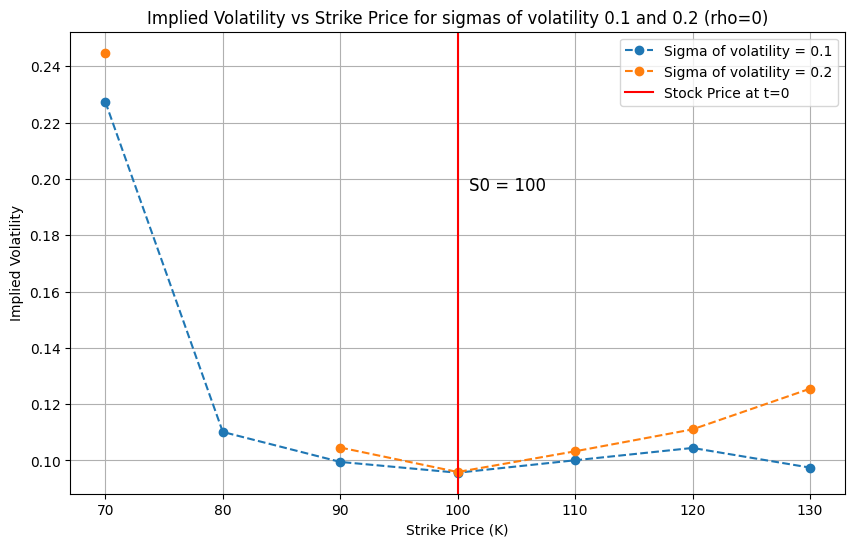

In [178]:
#plot implied volatilities for correlation = 0 and for different sigmas (volatility of volatility) in volatility process
num_iter = 10000
rho = 0

sigmas = [0.1, 0.2]

plt.figure(figsize=(10, 6))

for sigma in sigmas:
    strikes = [70, 80, 90, 100, 110, 120, 130]
    imp_vols = []

    for K in strikes:
        PVCT_sum = 0
        for i in range(num_iter):
            PVCT, T, r, S0 = stochastic_vol(rho=rho, K=K, sigma=sigma)
            PVCT_sum += PVCT

        aprox_c_opt_price = PVCT_sum / num_iter
        implied_vol_value = implied_vol(S0=S0, K=K, T=T, r=r, market_price=aprox_c_opt_price)
        
        if implied_vol_value > 1e-3:

            imp_vols.append(implied_vol_value)
        else:
            imp_vols.append(None)

    plt.plot(strikes, imp_vols, marker='o', linestyle='--', label=f'Sigma of volatility = {sigma}')

filtered_imp_vols = [v for v in imp_vols if v is not None]

plt.axvline(x=S0, color='red', linestyle='-', label='Stock Price at t=0')
plt.text(S0 + 1, max(filtered_imp_vols) * 0.8, f'S0 = {S0}', color='black', fontsize=12)
plt.title('Implied Volatility vs Strike Price for sigmas of volatility 0.1 and 0.2 (rho=0)')
plt.xlabel('Strike Price (K)')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()

plt.show()

In [181]:
#as you can see here the calculation of IV is not stable across strikes and different trials
#this problem is not due to any computational mistake (at least not in implied_vol() function) but rather due to numerical issues
#as public library yelds pricisly the same results, in all cases where we can obtain reaonable value for IV
strikes = [70, 80, 90, 100, 110, 120, 130]
for K in strikes:
    PVCT_sum = 0
        
    for i in range(1000):
        PVCT, T, r, S0 = stochastic_vol(rho=0, K=K)
        PVCT_sum += PVCT
    
    aprox_c_opt_price = PVCT_sum / 1000
    implied_vol_value = implied_vol(S0, K, T, r, aprox_c_opt_price)
    try:
        iv = implied_volatility.implied_volatility(aprox_c_opt_price, S0, K, T, r, 'c')
    
        print(implied_vol_value, iv)
    except:
        print(implied_vol_value)

0.2541932801483867 0.25419328014738934
0.1982186684271297 0.19821866842643104
0.11638933840862249 0.11638933840762267
0.10148363135490847 0.10148363135391057
0.10450921268801878 0.10450921268701863
0.11295554774185756 0.11295554774092284
0.009733733303898538 0.0


In [138]:
def check_bounds(S, K, T, r, market_price):
    sigma_low = 1e-10
    sigma_high = 50
    
    f_low = bs_call_price(S, K, T, r, sigma_low) - market_price
    f_high = bs_call_price(S, K, T, r, sigma_high) - market_price
    
    print(f"Objective function at low bound (sigma={sigma_low}): {f_low}")
    print(f"Objective function at high bound (sigma={sigma_high}): {f_high}")

# Example of calling this check function before using brentq
check_bounds(S=100, K=70, T=0.5, r=0, market_price=27.3)

Objective function at low bound (sigma=1e-10): 2.6999999999999993
Objective function at high bound (sigma=50): 72.7
